In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pyproj import Geod
from matplotlib.animation import FuncAnimation, PillowWriter

In [176]:
df = pd.read_json('../data/car_log_20250504_132551_small_track_gt.jsonl', lines=True)
df.head(10)

,timestamp,speed_mps,yaw,steering_angle,latitude,longitude,altitude
0,63798,1.699987,0.0,0.0,55.944493,-3.186458,0.652514
1,63998,1.699987,0.0,0.0,55.944493,-3.186453,0.652514
2,64198,1.699987,0.0,0.0,55.944493,-3.186448,0.652513
3,64398,1.699987,0.0,0.0,55.944493,-3.186442,0.652513
4,64598,1.699987,0.0,0.0,55.944493,-3.186437,0.652512
5,64798,1.699987,0.0,0.0,55.944493,-3.186431,0.652512
6,64998,1.699987,0.0,0.0,55.944493,-3.186426,0.652511
7,65198,1.699987,0.0,0.0,55.944493,-3.186420,0.652511
8,65398,1.699987,0.0,0.0,55.944493,-3.186415,0.652510
9,65598,1.699987,0.0,0.0,55.944493,-3.186409,0.652510


In [177]:
df.shape

(303, 7)

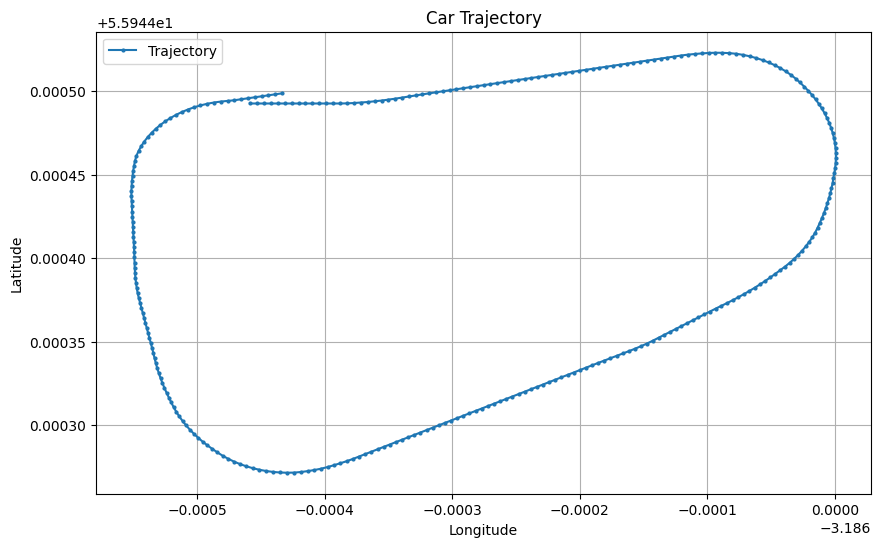

In [178]:
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
plt.title('Car Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

In [179]:
# Remove the last 6 entries
df = df.iloc[:-6]

# Calculate the number of entries to add
entries_to_add = waypoint_gap * (num_waypoints + 1)

first_entries = df.iloc[:entries_to_add]

# Add the selected entries to the end of the DataFrame
df = pd.concat([df, first_entries], ignore_index=True)

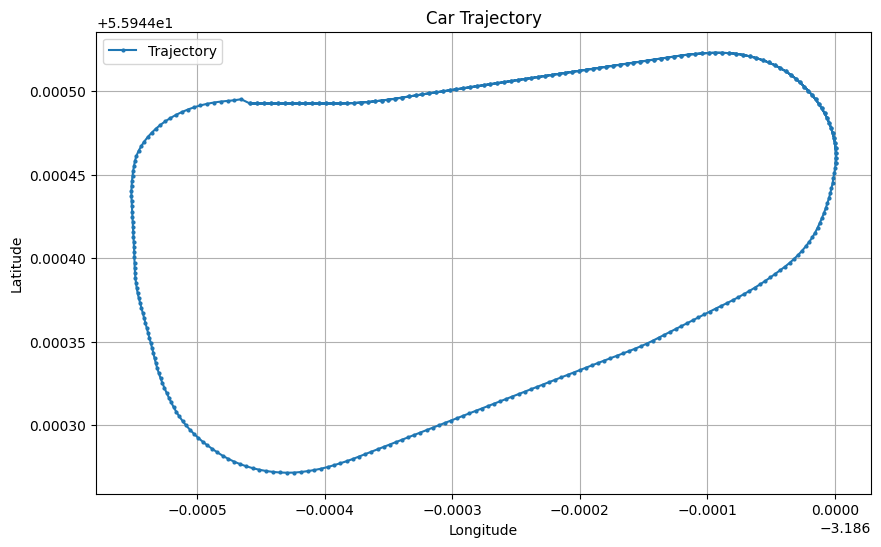

In [180]:
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
plt.title('Car Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

In [181]:
# Initialize Geod object for coordinate transformations
geod = Geod(ellps="WGS84")

# Function to calculate local coordinates (x, y) from global coordinates
def calculate_local_coordinates(lat, lon, waypoints):
    local_coords = []
    for wp_lat, wp_lon in waypoints:
        azimuth, _, distance = geod.inv(lon, lat, wp_lon, wp_lat)
        x = distance * np.cos(np.radians(azimuth))
        y = distance * np.sin(np.radians(azimuth))
        local_coords.append((x, y))
    return local_coords

# Create the dataset
dataset = []
waypoint_gap = 10  # Define the gap between waypoints
num_waypoints = 9
for i in range(len(df) - waypoint_gap * (num_waypoints + 1)):
    for j in range(waypoint_gap-1, -1, -1):
        current_row = df.iloc[i]
        waypoints = df.iloc[i + waypoint_gap - j : i + waypoint_gap * 10 -j : waypoint_gap][["latitude", "longitude"]].values
        local_coords = calculate_local_coordinates(current_row["latitude"], current_row["longitude"], waypoints)
        dataset.append({
            "current_latitude": current_row["latitude"],
            "current_longitude": current_row["longitude"],
            "steering_angle": current_row["steering_angle"],
            "waypoints": local_coords
        })

# Convert the dataset to a DataFrame
training_data = pd.DataFrame(dataset)
training_data.head()

,current_latitude,current_longitude,steering_angle,waypoints
0,55.944493,-3.186458,0.0,"[(8.296151559885242e-07, 0.33999740600102224),..."
1,55.944493,-3.186458,0.0,"[(1.6560681867453635e-06, 0.6799948119741587),..."
2,55.944493,-3.186458,0.0,"[(2.484487295084824e-06, 1.0199922179749223), ..."
3,55.944493,-3.186458,0.0,"[(3.2678578689635556e-06, 1.3599702877715365),..."
4,55.944493,-3.186458,0.0,"[(4.142950242612689e-06, 1.699987029948366), (..."


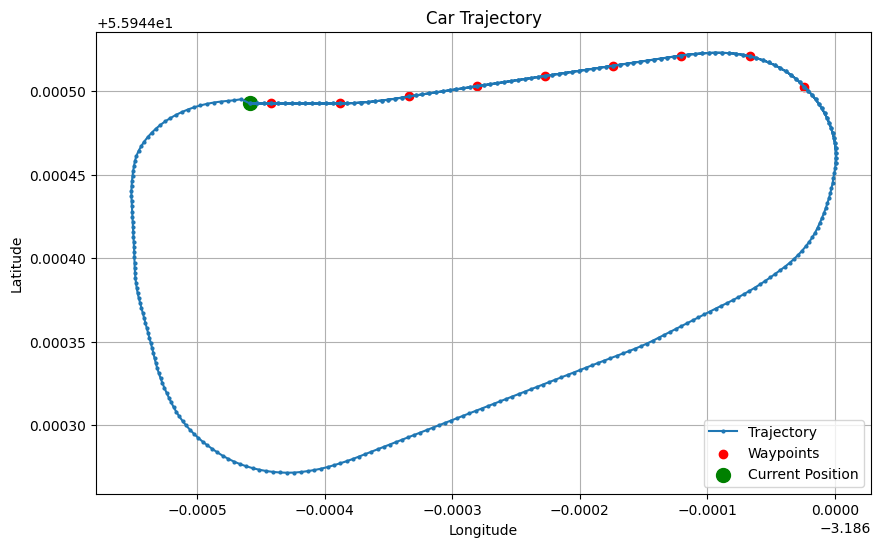

In [182]:
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
plt.title('Car Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

# Add one training_data entry to the plot
entry = training_data.iloc[2]  # Select an entry from the dataset
local_coords = np.array(entry['waypoints'])

# Convert local coordinates back to global for plotting
global_coords = []
for x, y in local_coords:
    lon, lat, _ = geod.fwd(entry['current_longitude'], entry['current_latitude'], np.degrees(np.arctan2(y, x)), np.hypot(x, y))
    global_coords.append((lat, lon))

plot_waypoints = np.array(global_coords)

# Plot the waypoints
plt.scatter(plot_waypoints[:, 1], plot_waypoints[:, 0], color='red', label='Waypoints')

# Add the current position
plt.scatter(entry['current_longitude'], entry['current_latitude'], color='green', label='Current Position', s=100)

plt.legend()
plt.show()

In [183]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
ax.set_title('Car Trajectory with Waypoints')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()
trajectory_line, = ax.plot([], [], 'ro-', label='Waypoints')  # Line for waypoints
current_position, = ax.plot([], [], 'go', label='Current Position', markersize=10)  # Current position marker
ax.legend()

# Function to update the plot for each frame
def update(frame):
    entry = training_data.iloc[frame]
    local_coords = np.array(entry['waypoints'])

    # Convert local coordinates back to global for plotting
    global_coords = []
    for x, y in local_coords:
        lon, lat, _ = geod.fwd(entry['current_longitude'], entry['current_latitude'], np.degrees(np.arctan2(y, x)), np.hypot(x, y))
        global_coords.append((lat, lon))

    plot_waypoints = np.array(global_coords)

    # Update the trajectory line and current position
    trajectory_line.set_data(plot_waypoints[:, 1], plot_waypoints[:, 0])
    current_position.set_data([entry['current_longitude']], [entry['current_latitude']])
    return trajectory_line, current_position

# Create the animation
num_frames = waypoint_gap*3
ani = FuncAnimation(fig, update, frames=num_frames, interval=100, blit=True)

# Save the animation as a GIF
gif_path = './imgs/car_trajectory.gif'
ani.save(gif_path, writer=PillowWriter(fps=10))
plt.close(fig)

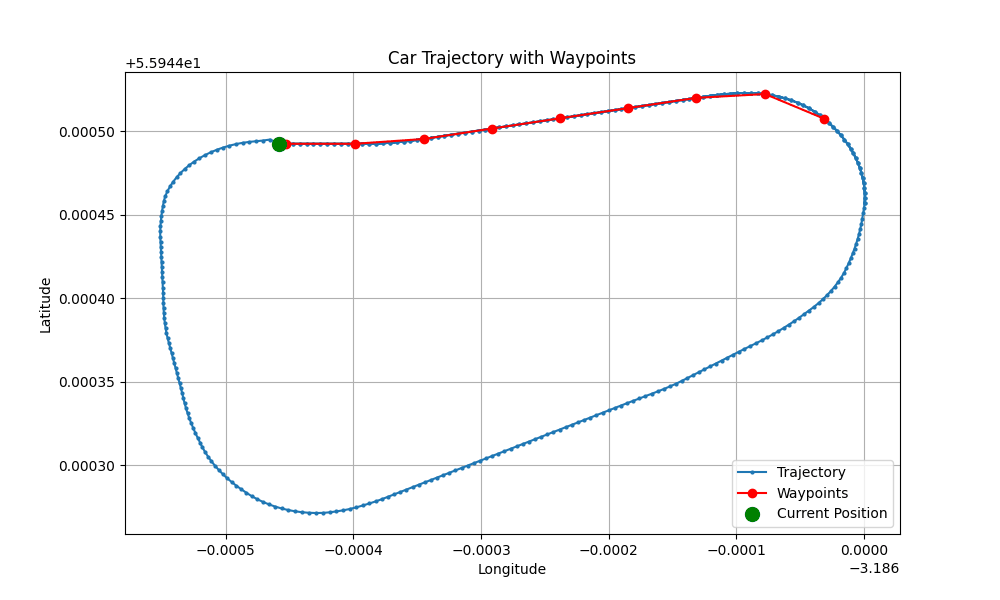

In [184]:
Image(filename=gif_path)

In [185]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
ax.set_title('Car Trajectory with Waypoints')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid()
trajectory_line, = ax.plot([], [], 'ro-', label='Waypoints')  # Line for waypoints
current_position, = ax.plot([], [], 'go', label='Current Position', markersize=10)  # Current position marker
ax.legend()

# Function to update the plot for each frame
def update(frame):
    entry = training_data.iloc[frame % len(training_data)]  # Wrap around using modulo
    local_coords = np.array(entry['waypoints'])

    # Convert local coordinates back to global for plotting
    global_coords = []
    for x, y in local_coords:
        lon, lat, _ = geod.fwd(entry['current_longitude'], entry['current_latitude'], np.degrees(np.arctan2(y, x)), np.hypot(x, y))
        global_coords.append((lat, lon))

    plot_waypoints = np.array(global_coords)

    # Update the trajectory line and current position
    trajectory_line.set_data(plot_waypoints[:, 1], plot_waypoints[:, 0])
    current_position.set_data([entry['current_longitude']], [entry['current_latitude']])
    return trajectory_line, current_position

# Update the number of frames to show the last entries with wrapping
num_frames = len(training_data) - waypoint_gap * 10
ani = FuncAnimation(fig, update, frames=range(num_frames, len(training_data)), interval=100, blit=True)

# Save the updated animation as a GIF
gif_path = './imgs/car_trajectory_last_entries_wrapped.gif'
ani.save(gif_path, writer=PillowWriter(fps=10))
plt.close(fig)

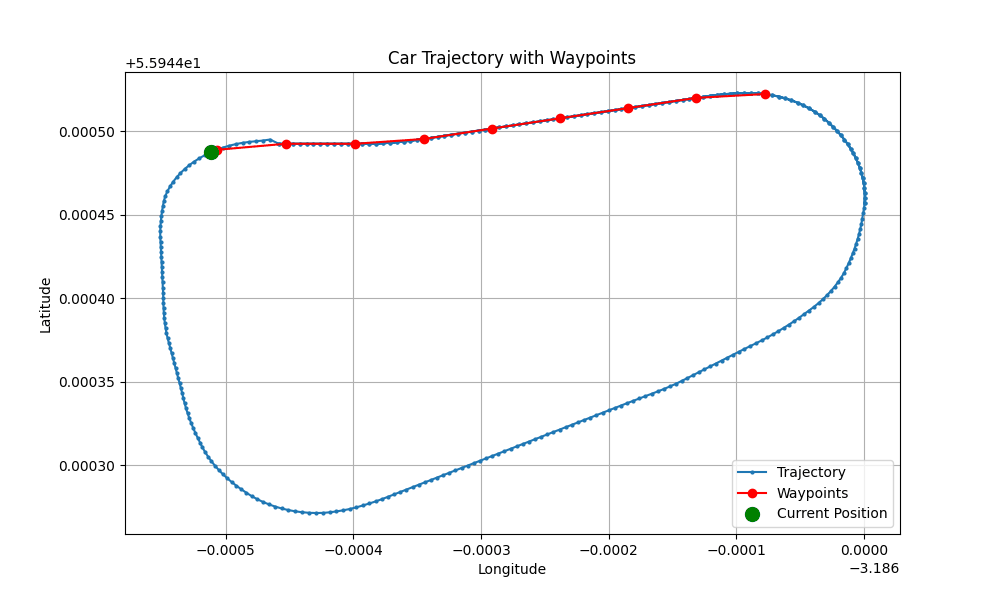

In [186]:
Image(filename=gif_path)

In [187]:
training_data.shape

(2970, 4)

In [188]:
# Expand waypoints into individual columns
max_waypoints = len(training_data['waypoints'].iloc[0])  # Determine the maximum number of waypoints
for i in range(max_waypoints):
    training_data[f'waypoint{i+1}_lat'] = training_data['waypoints'].apply(lambda x: x[i][0])
    training_data[f'waypoint{i+1}_lon'] = training_data['waypoints'].apply(lambda x: x[i][1])

# Drop the original waypoints column if no longer needed
training_data_cleaned = training_data.drop(columns=['waypoints', 'current_latitude', 'current_longitude'])

# Display the updated DataFrame
training_data_cleaned.head()

,steering_angle,waypoint1_lat,waypoint1_lon,waypoint2_lat,waypoint2_lon,waypoint3_lat,waypoint3_lon,waypoint4_lat,waypoint4_lon,waypoint5_lat,waypoint5_lon,waypoint6_lat,waypoint6_lon,waypoint7_lat,waypoint7_lon,waypoint8_lat,waypoint8_lon,waypoint9_lat,waypoint9_lon
0,0.0,8.296152e-07,0.339997,0.000009,3.739971,0.321126,7.116852,1.017355,10.444594,1.698330,13.775675,2.379285,17.106732,3.060279,20.437836,3.313977,23.808480,1.665285,26.709838
1,0.0,1.656068e-06,0.679995,0.000010,4.079969,0.394778,7.448745,1.085435,10.777683,1.766408,14.108763,2.447402,17.439863,3.128376,20.770944,3.240861,24.140425,1.402567,26.925549
2,0.0,2.484487e-06,1.019992,0.000011,4.419966,0.472521,7.779717,1.153550,11.110810,1.834506,14.441871,2.515499,17.772971,3.196474,21.104052,3.145777,24.466783,1.131188,27.130259
3,0.0,3.267858e-06,1.359970,0.008695,4.759774,0.540673,8.112838,1.221629,11.443899,1.902603,14.774978,2.583597,18.106080,3.254098,21.439049,3.029210,24.786046,0.855228,27.328842
4,0.0,4.142950e-06,1.699987,0.031370,5.098981,0.608749,8.445921,1.289725,11.777005,1.970720,15.108107,2.651675,18.439167,3.299015,21.776026,2.891616,25.096855,0.570854,27.515076


In [189]:
training_data_cleaned.to_csv('../data/datasets/training_data.csv', index=False)

# Generar el ground truth

In [190]:
waypoints_df = pd.DataFrame({
    'Longitude': df['longitude'][::waypoint_gap],
    'Latitude': df['latitude'][::waypoint_gap]
})

waypoints_df = waypoints_df.iloc[:-(waypoint_gap)]
waypoints_df = pd.concat([waypoints_df, waypoints_df.iloc[:1]], ignore_index=True)
waypoints_df.sample(5)

,Longitude,Latitude
4,-3.186243,55.944507
14,-3.186120,55.944359
26,-3.186550,55.944413
13,-3.186076,55.944377
29,-3.186497,55.944491


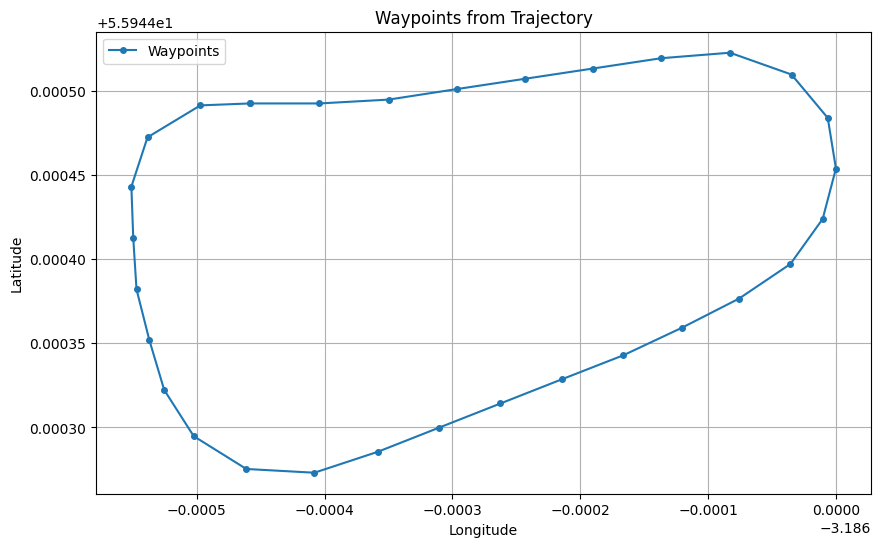

In [191]:
plt.figure(figsize=(10, 6))
plt.plot(waypoints_df['Longitude'], waypoints_df['Latitude'], marker='o', markersize=4, linestyle='-', label='Waypoints')
plt.title('Waypoints from Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

In [192]:
waypoints_df.to_csv('../data/datasets/waypoints.csv', index=False)